# Mask R-CNN - Inspect Buccin Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [80]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.buccin import buccin

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/home/jupyter/object-detection/Mask_RCNN/samples/buccin/mask_rcnn_buccin_0030.h5"  # TODO: update this path

## Configurations

In [81]:
config = buccin.CustomConfig()
BALLOON_DIR = "/home/jupyter/object-detection/Mask_RCNN/samples/buccin/dataset"

In [82]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [83]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [84]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [85]:
# Load validation dataset
dataset = buccin.CustomDataset()
dataset.load_custom(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 664
Classes: ['BG', 'buccin']


## Load Model

In [86]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [87]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = BALLON_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/jupyter/object-detection/Mask_RCNN/samples/buccin/mask_rcnn_buccin_0030.h5


## Run Detection

image ID: buccin.CAM-TEMPO-MINI-2_20141102141048.jpg (11) /home/jupyter/object-detection/Mask_RCNN/samples/buccin/dataset/val/CAM-TEMPO-MINI-2_20141102141048.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  451.00000  max:  949.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


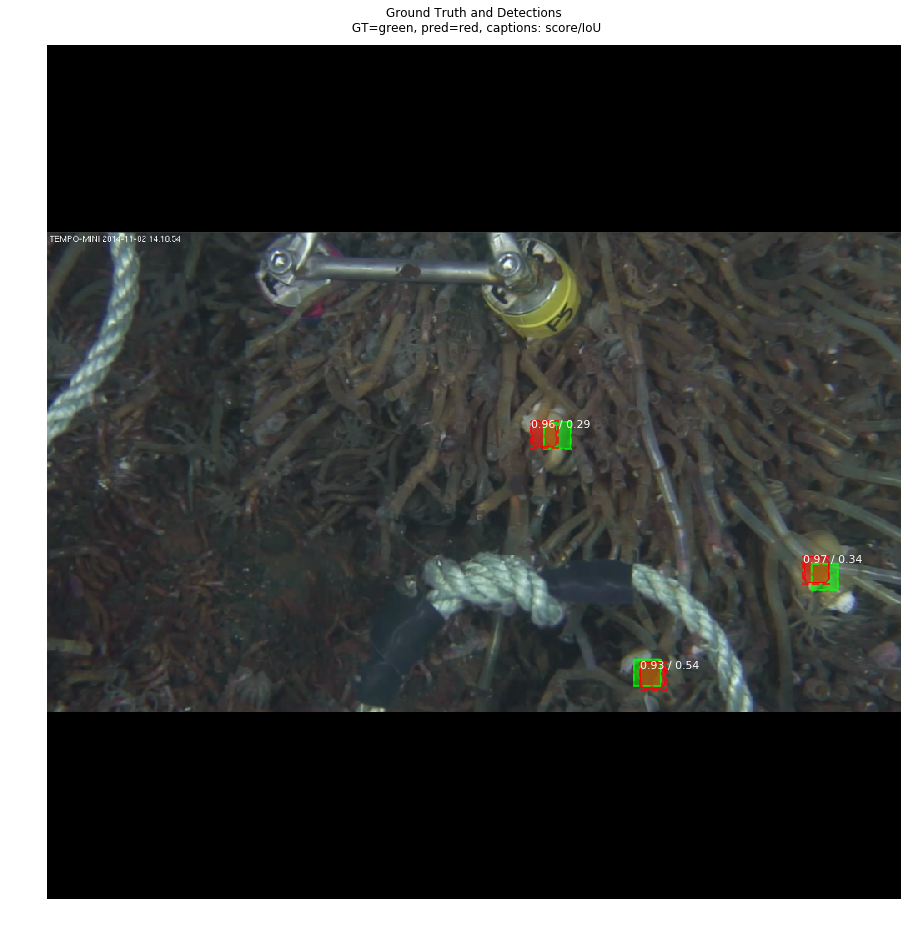

In [95]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                            dataset.class_names, r['scores'], ax=ax,
#                            title="Predictions")
visualize.display_differences(image,
                        gt_bbox, gt_class_id, gt_mask,
                        r['rois'], r['class_ids'], r['scores'], r['masks'],
                        dataset.class_names, title="", ax=ax,
                        show_mask=True, show_box=True,
                        iou_threshold=0.01, score_threshold=0.5)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [89]:
## Evaluation

In [90]:
### for the same image as above

In [91]:
inference_config = InferenceConfig()

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
APs = []
Precisions = []
Recalls = []

# Load image and ground truth data
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)
molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
# Run object detection
results = model.detect([image], verbose=0)
r = results[0]
# Compute AP
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
APs.append(AP)
    
recall, positive_ids = utils.compute_recall(r["rois"], gt_bbox, 0.01)

print("mAP: ", np.mean(APs))
print("mRecall: ", recall)

mAP:  0.0
mRecall:  1.0


In [92]:
### for multiple images with different IoU for Recall

In [94]:
inference_config = InferenceConfig()

# Compute VOC-Style mAP @ various IoU
# Running on all test images
#img_id = np.random.choice(dataset.image_ids, len(dataset.image_ids))
img_id = np.random.choice(dataset.image_ids, 150)
APs = []
APs1 = []
APs01 = []
Recalls01 = []
Recalls1 = []
Recalls5 = []
mRecalls01 = []
mRecalls1 = []
mRecalls5 = []

for i_id in img_id:
#for i_id in dataset.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config,
                               i_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
#    mRecalls5.append(recalls)
    
#    AP1, precisions1, recalls1, overlaps1 =\
#        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                         r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.1)
#    APs1.append(AP1)
#    mRecalls1.append(recalls1)
    
    AP01, precisions01, recalls01, overlaps01 =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.01)
    APs01.append(AP01)
#    mRecalls01.append(recalls01)
    
    recall01, positive_ids01 = utils.compute_recall(r["rois"], gt_bbox, 0.01)
    Recalls01.append(recall01)
#    recall1, positive_ids1 = utils.compute_recall(r["rois"], gt_bbox, 0.1)
#    Recalls1.append(recall1)
    recall5, positive_ids5 = utils.compute_recall(r["rois"], gt_bbox, 0.5)
    Recalls5.append(recall5)

print("mAP with IoU 0.5: ", np.mean(APs))
#print("mAP with IoU 0.1: ", np.mean(APs1))
print("mAP with IoU 0.01: ", np.mean(APs01))

print("Recall with IoU 0.5: ", np.mean(Recalls5))
#print("Recall with IoU 0.1: ", np.mean(Recalls1))
print("Recall with IoU 0.01: ", np.mean(Recalls01))


mAP with IoU 0.5:  0.4225319701137094
mAP with IoU 0.01:  0.7883303751216701
Recall with IoU 0.5:  0.5088586043586044
Recall with IoU 0.01:  0.8138396788396788
